# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

#### Data Cleaning for Portfolio, Profile and Transcript

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
# Unique values for "Channels"
np.unique(portfolio['channels']).tolist()

[['email', 'mobile', 'social'],
 ['web', 'email'],
 ['web', 'email', 'mobile'],
 ['web', 'email', 'mobile', 'social']]

In [5]:
# Unique values for "offer_type"
portfolio['offer_type'].unique().tolist()

['bogo', 'informational', 'discount']

In [6]:
def clean_portfolio(portfolio):
    '''
    Data Cleaning for Portfolio Dataframe
    
    INPUT:
    portfolio - Portfolio Dataframe To Be Cleaned
    
    OUTPUT:
    cleaned_portfolio - The Cleaned Portfolio Dataframe
    
    '''
    cleaned_portfolio = portfolio.copy()
    
    # Apply one hot encoding to "Channels" column
    cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # Apply one hot encoding to "Offer Type" column
    offer_type = pd.get_dummies(cleaned_portfolio['offer_type'])
    
    # Drop the "Channels" and "Offer Type" columns
    cleaned_portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # Combine the "cleaned_portfolio" and "offer_type" dataframe to form a final cleaned dataframe
    cleaned_portfolio = pd.concat([cleaned_portfolio, offer_type], axis=1, sort=False)
    
    # Rename "ID" to "Offer ID"
    cleaned_portfolio.rename(columns={'id': 'offer_id'}, inplace=True)
    
    return cleaned_portfolio

cleaned_portfolio = clean_portfolio(portfolio)

In [7]:
cleaned_portfolio.head()

,difficulty,duration,offer_id,reward,web,email,mobile,social,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


In [8]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [9]:
profile.shape

(17000, 5)

In [10]:
def clean_profile(profile):
    '''
    Data Cleaning for Profile Dataframe
    
    INPUT:
    profile - Profile Dataframe To Be Cleaned
    
    OUTPUT:
    cleaned_profile - The Cleaned Profile Dataframe    
  
    '''
    cleaned_profile = profile.copy()
    
    # Age (numeric): Missing value encoded as 118
    cleaned_profile['age'] = cleaned_profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # Drop all missing values
    cleaned_profile.dropna(inplace=True)
    
    # Number of days since a user become Starbucks members : "Members Tenure"
    cleaned_profile['members_tenure'] = datetime.datetime.today().date() - pd.to_datetime(cleaned_profile['became_member_on'], format='%Y%m%d').dt.date
    cleaned_profile['members_tenure'] = cleaned_profile['members_tenure'].dt.days
    
    # Rename "ID" to "Customer ID"
    cleaned_profile.rename(columns={'id': 'customer_id'}, inplace=True)
    
    return cleaned_profile

cleaned_profile = clean_profile(profile)

In [11]:
cleaned_profile.head()

,age,became_member_on,gender,customer_id,income,members_tenure
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,860
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,927
5,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,575
8,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,651
12,58.0,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,741


In [12]:
cleaned_profile.shape

(14825, 6)

In [13]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [14]:
# Unique values for "Event"
transcript['event'].unique().tolist()

['offer received', 'offer viewed', 'transaction', 'offer completed']

In [15]:
def clean_transcript(transcript):
    '''
    Data Cleaning for Transcript Dataframe and Return Dataframe contains Offer Events
    
    INPUT:
    transcript - Transcript Dataframe To Be Cleaned
    
    OUTPUT:
    cleaned_transcript - The Cleaned Transcript Dataframe    
  
    '''
    cleaned_transcript_t = transcript.copy()
    
    # Apply one hot encoding to "Event" column
    cleaned_transcript_t['offer_received'] = cleaned_transcript_t['event'].apply(lambda x: 1 if 'offer received' in x else 0)
    cleaned_transcript_t['offer_viewed'] = cleaned_transcript_t['event'].apply(lambda x: 1 if 'offer viewed' in x else 0)
    cleaned_transcript_t['offer_completed'] = cleaned_transcript_t['event'].apply(lambda x: 1 if 'offer completed' in x else 0)
    cleaned_transcript_t['transaction'] = cleaned_transcript_t['event'].apply(lambda x: 1 if 'transaction' in x else 0)
        
    # Apply one hot encoding to "Value" column to identify "Offers" / "Payment" related
    cleaned_transcript_t['offers'] = cleaned_transcript_t['value'].apply(lambda x: 1 if ('offer id' in x) or ('offer_id' in x) else 0)
    cleaned_transcript_t['payment'] = cleaned_transcript_t['value'].apply(lambda x: 1 if 'amount' in x else 0)

    # Split the dataframe to "Offers" (i.e. offer received, offer viewed, offer completed) / "Payment" related 
    offers = cleaned_transcript_t[cleaned_transcript_t['offers']==1]
    payment = cleaned_transcript_t[cleaned_transcript_t['offers']==0]

    # Extract the "Offer ID" / "Amount" from value column
    offers['offer_id'] = offers['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
    payment['amount'] = payment['value'].apply(lambda x: x['amount'] if ('amount' in x) else None)

    # Append dataframe "Offers" & "Payment" as "Cleaned Transcript"
    cleaned_transcript = pd.concat([offers, payment], sort=False)
    
    # Rename "Person" to "Customer ID"
    cleaned_transcript.rename(columns={'person': 'customer_id'}, inplace=True)
    
    return cleaned_transcript

cleaned_transcript = clean_transcript(transcript)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
cleaned_transcript.head()

,event,customer_id,time,value,offer_received,offer_viewed,offer_completed,transaction,offers,payment,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1,0,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},1,0,0,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},1,0,0,0,1,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},1,0,0,0,1,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},1,0,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


### Question 1

**Is there any different in customers' demographic that respond best to a specific type of offer ?**

In [17]:
# Extract "Offers" related transactions 
offers = cleaned_transcript[cleaned_transcript['offers']==1]
offers.head()

,event,customer_id,time,value,offer_received,offer_viewed,offer_completed,transaction,offers,payment,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1,0,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},1,0,0,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},1,0,0,0,1,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},1,0,0,0,1,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},1,0,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [18]:
# Merge with Cleaned Profile Dataframe
offers_profile = pd.merge(offers, cleaned_profile[['customer_id', 'age', 'gender', 'income','members_tenure']], left_on='customer_id', right_on='customer_id', how='left')
offers_profile.head()

,event,customer_id,time,value,offer_received,offer_viewed,offer_completed,transaction,offers,payment,offer_id,amount,age,gender,income,members_tenure
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1,0,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,F,100000.0,927.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},1,0,0,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},1,0,0,0,1,0,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,M,70000.0,575.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},1,0,0,0,1,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},1,0,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,NaN,NaN


In [19]:
# Offers Details - Merge with Clean Portfolio
offers_details = pd.merge(offers_profile, cleaned_portfolio[['offer_id', 'duration', 'difficulty', 'reward', 'web', 'email', 'mobile', 'social', 'bogo', 'discount', 'informational']], left_on='offer_id', right_on='offer_id', how='left')
offers_details.head()

,event,customer_id,time,value,offer_received,offer_viewed,offer_completed,transaction,offers,payment,...,duration,difficulty,reward,web,email,mobile,social,bogo,discount,informational
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1,0,0,0,1,0,...,7,5,5,1,1,1,0,1,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},1,0,0,0,1,0,...,10,20,5,1,1,0,0,0,1,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},1,0,0,0,1,0,...,7,10,2,1,1,1,0,0,1,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},1,0,0,0,1,0,...,10,10,2,1,1,1,1,0,1,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},1,0,0,0,1,0,...,5,10,10,1,1,1,1,1,0,0


In [20]:
# Distribution of "Age"
offers_details['age'].describe()

count    148805.000000
mean         54.779282
std          17.193533
min          18.000000
25%          43.000000
50%          56.000000
75%          67.000000
max         101.000000
Name: age, dtype: float64

In [21]:
# Distribution of "Income"
offers_details['income'].describe()

count    148805.000000
mean      66414.119149
std       21496.947967
min       30000.000000
25%       51000.000000
50%       65000.000000
75%       81000.000000
max      120000.000000
Name: income, dtype: float64

In [22]:
# Create "Age Group" column
age_bins= [0, 18, 25, 35, 45, 55, 65, 75, 85, 110]
offers_details['age_group'] = pd.cut(offers_details['age'], bins=age_bins, right=False)

# Create "Income Group" column
income_bins= [0, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 120000]
offers_details['income_group'] = pd.cut(offers_details['income'], bins=income_bins, right=False)

offers_details.head()

,event,customer_id,time,value,offer_received,offer_viewed,offer_completed,transaction,offers,payment,...,reward,web,email,mobile,social,bogo,discount,informational,age_group,income_group
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1,0,0,0,1,0,...,5,1,1,1,0,1,0,0,"[75, 85)","[100000, 120000)"
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},1,0,0,0,1,0,...,5,1,1,0,0,0,1,0,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},1,0,0,0,1,0,...,2,1,1,1,0,0,1,0,"[65, 75)","[70000, 80000)"
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},1,0,0,0,1,0,...,2,1,1,1,1,0,1,0,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},1,0,0,0,1,0,...,10,1,1,1,1,1,0,0,NaN,NaN


In [23]:
# Overall Respond Rate by Offer Type

# Aggregate the Offer Received by Profile
o_offer_received = offers_details[offers_details['offer_received']==1].agg({'bogo':'sum', 'discount':'sum', 'informational':'sum'})
o_real_offer_received = offers_details[(offers_details['offer_received']==1) & ((offers_details['bogo']==1)|(offers_details['discount']==1))].agg({'bogo':'sum', 'discount':'sum'})

# Aggregate the Offer Viewed by Profile
o_offer_viewed = offers_details[offers_details['offer_viewed']==1].agg({'bogo':'sum', 'discount':'sum', 'informational':'sum'})
o_real_offer_viewed = offers_details[(offers_details['offer_viewed']==1) & ((offers_details['bogo']==1)|(offers_details['discount']==1))].agg({'bogo':'sum', 'discount':'sum'})

# Aggregate the Offer Completed by Profile
o_real_offer_completed = offers_details[(offers_details['offer_completed']==1) & ((offers_details['bogo']==1)|(offers_details['discount']==1))].agg({'bogo':'sum', 'discount':'sum'})

# Derived Percentage of Offers Viewed / Offer Received
o_perc_offer_viewed = o_offer_viewed/o_offer_received*100

# Derived Percentage of Offers Completed / Offer Viewed
o_perc_offer_completed = o_real_offer_completed/o_real_offer_received*100

bogo             83.442080
discount         70.212487
informational    71.092878
dtype: float64


Text(0,0.5,'Percentage')

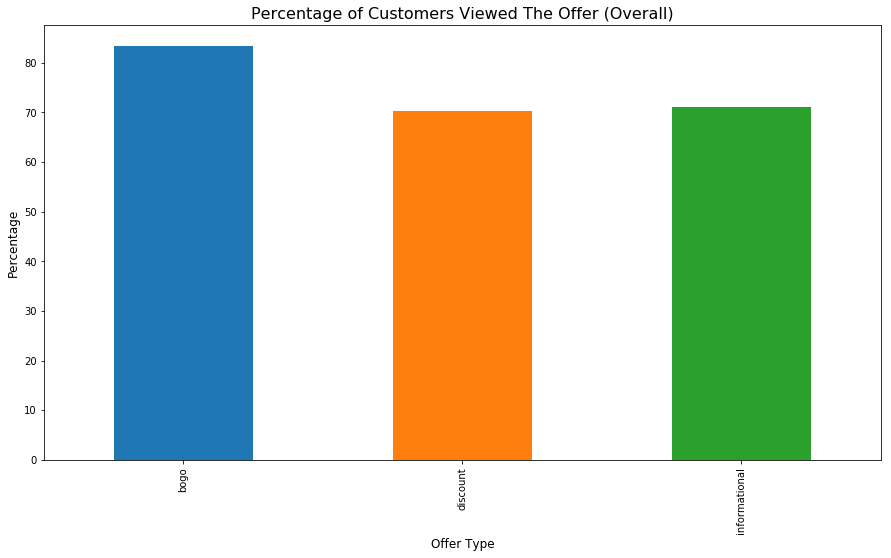

In [25]:
print(o_perc_offer_viewed)

# Visualize the Percentage of Offers Viewed in Bar Chart
bar_chart1 = o_perc_offer_viewed.plot(kind='bar', figsize=(15,8))
plt.title('Percentage of Customers Viewed The Offer (Overall)', fontdict={'fontsize':16})
bar_chart1.set_xlabel('Offer Type', fontsize=12)
bar_chart1.set_ylabel('Percentage', fontsize=12)    

bogo        51.375455
discount    58.638641
dtype: float64


Text(0,0.5,'Percentage')

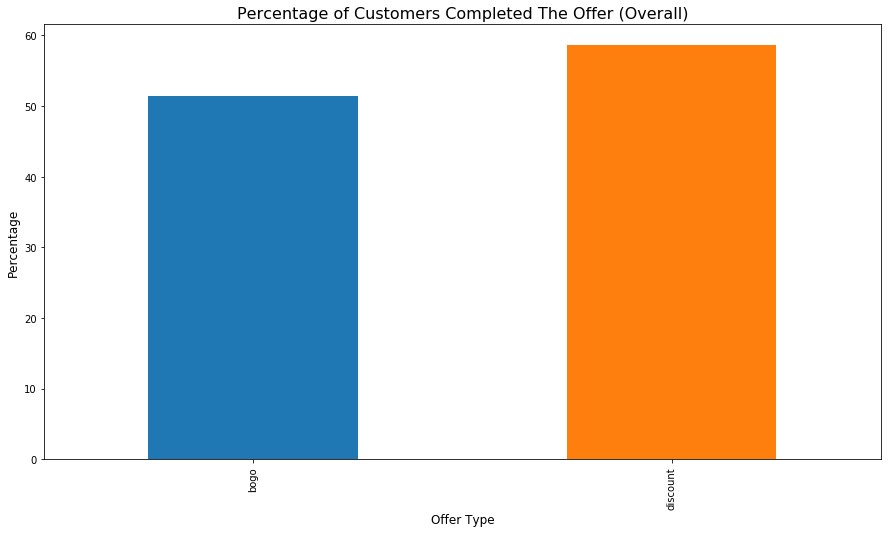

In [24]:
print(o_perc_offer_completed)

# Visualize the Percentage of Offers Completed in Bar Chart
bar_chart1 = o_perc_offer_completed.plot(kind='bar', figsize=(15,8))
plt.title('Percentage of Customers Completed The Offer (Overall)', fontdict={'fontsize':16})
bar_chart1.set_xlabel('Offer Type', fontsize=12)
bar_chart1.set_ylabel('Percentage', fontsize=12)    

In [25]:
def offer_viewed_completed(profile='', label=''):
    '''
    Generate the Percentage of Customer Viewed The Offer and Visualize it in a Bar Chart
    - By Customers' Demographic i.e. Gender, Age Group and Income Group
    '''
    
    # Aggregate the Offer Received by Profile
    offer_received = offers_details[offers_details['offer_received']==1].groupby([profile]).agg({'bogo':'sum', 'discount':'sum', 'informational':'sum', 'customer_id':'count'}).rename(columns={'bogo':'BOGO', 'discount':'Discount', 'informational':'Informational', 'customer_id':'Target Base'})
    real_offer_received = offers_details[(offers_details['offer_received']==1) & ((offers_details['bogo']==1)|(offers_details['discount']==1))].groupby([profile]).agg({'bogo':'sum', 'discount':'sum', 'customer_id':'count'}).rename(columns={'bogo':'BOGO', 'discount':'Discount', 'customer_id':'Target Base'})
    
    # Aggregate the Offer Viewed by Profile
    offer_viewed = offers_details[offers_details['offer_viewed']==1].groupby([profile]).agg({'bogo':'sum', 'discount':'sum', 'informational':'sum', 'customer_id':'count'}).rename(columns={'bogo':'BOGO', 'discount':'Discount', 'informational':'Informational', 'customer_id':'Target Base'})
    real_offer_viewed = offers_details[(offers_details['offer_viewed']==1) & ((offers_details['bogo']==1)|(offers_details['discount']==1))].groupby([profile]).agg({'bogo':'sum', 'discount':'sum', 'customer_id':'count'}).rename(columns={'bogo':'BOGO', 'discount':'Discount', 'customer_id':'Target Base'})

    # Aggregate the Offer Completed by Profile
    real_offer_completed = offers_details[(offers_details['offer_completed']==1) & ((offers_details['bogo']==1)|(offers_details['discount']==1))].groupby([profile]).agg({'bogo':'sum', 'discount':'sum', 'customer_id':'count'}).rename(columns={'bogo':'BOGO', 'discount':'Discount', 'customer_id':'Target Base'})

    # Derived Percentage of Offers Viewed / Offer Received
    perc_offer_viewed = offer_viewed/offer_received*100
    
    # Derived Percentage of Offers Completed / Offer Viewed
    #perc_offer_completed = real_offer_completed/real_offer_viewed*100
    perc_offer_completed = real_offer_completed/real_offer_received*100
    
    # Visualize the Percentage of Offers Viewed in Bar Chart
    bar_chart1 = perc_offer_viewed.plot(kind='bar', figsize=(15,8))
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    plt.title('Percentage of Customers Viewed The Offer\n(by {})'.format(label), fontdict={'fontsize':16})
    bar_chart1.set_xlabel(label, fontsize=12)
    bar_chart1.set_ylabel('Percentage', fontsize=12)
    
    # Visualize the Percentage of Offers Completed in Bar Chart
    bar_chart2 = perc_offer_completed.plot(kind='bar', figsize=(15,8))
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    plt.title('Percentage of Customers Completed The Offer\n(by {})'.format(label), fontdict={'fontsize':16})
    bar_chart2.set_xlabel(label, fontsize=12)
    bar_chart2.set_ylabel('Percentage', fontsize=12)

    print(perc_offer_viewed)
    print(perc_offer_completed)

             BOGO   Discount  Informational  Target Base
gender                                                  
F       83.307517  70.666179      70.603106    75.706585
M       82.726197  67.936694      69.895599    74.224344
O       88.983051  80.926431      82.564103    84.388646
             BOGO   Discount  Target Base
gender                                   
F       68.346241  72.886777    70.613195
M       49.395055  58.317051    53.877364
O       69.209040  69.754768    69.486824


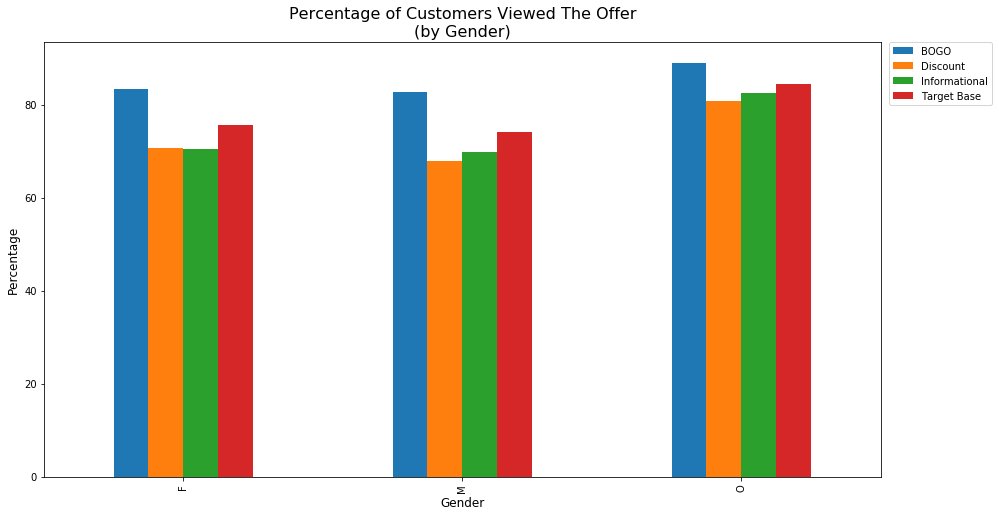

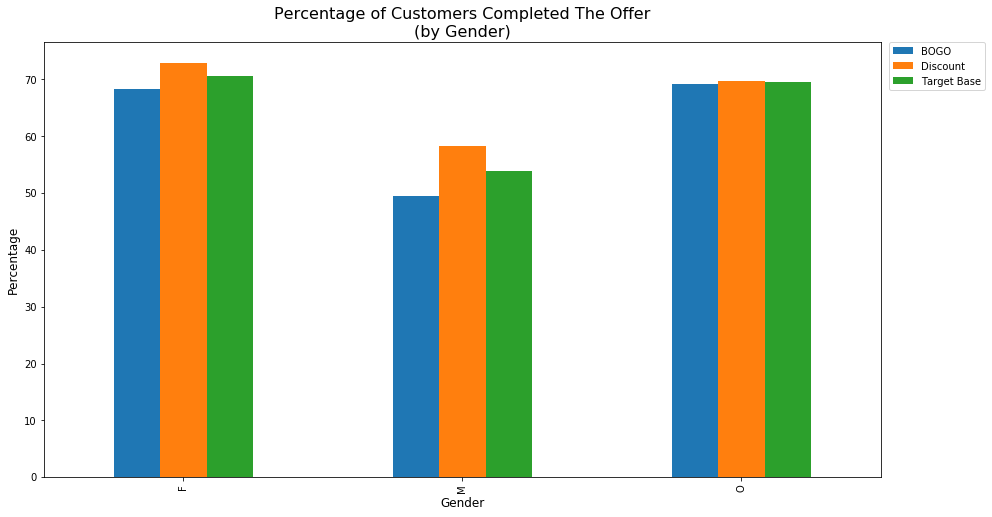

In [28]:
# By Gender
offer_viewed_completed(profile='gender', label='Gender')

                BOGO   Discount  Informational  Target Base
age_group                                                  
[0, 18)          NaN        NaN            NaN          NaN
[18, 25)   80.735108  58.228643      67.708333    69.095988
[25, 35)   80.808081  61.319637      61.456628    69.091201
[35, 45)   85.289747  70.838323      75.059666    77.484787
[45, 55)   84.061459  70.778240      74.320353    76.844537
[55, 65)   82.419014  71.569407      69.580996    75.489879
[65, 75)   82.371722  70.843701      69.149909    75.104603
[75, 85)   84.485981  70.380559      72.902098    76.431839
[85, 110)  83.031459  68.996063      64.116576    73.603673
                BOGO   Discount  Target Base
age_group                                   
[0, 18)          NaN        NaN          NaN
[18, 25)   40.811153  51.633166    46.246057
[25, 35)   45.292929  53.575662    49.480623
[35, 45)   53.818722  62.215569    58.001491
[45, 55)   59.829693  65.489233    62.630890
[55, 65)   61.989256  67.

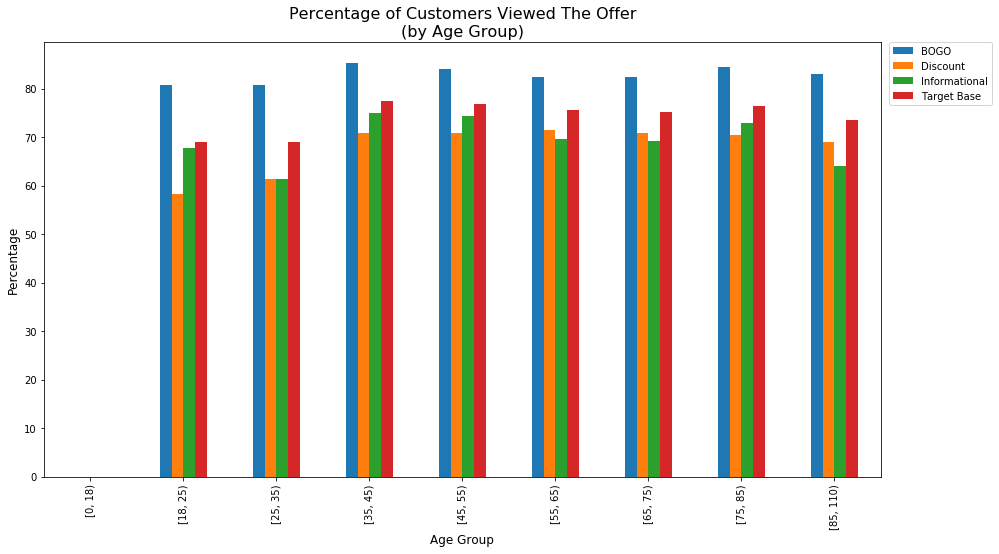

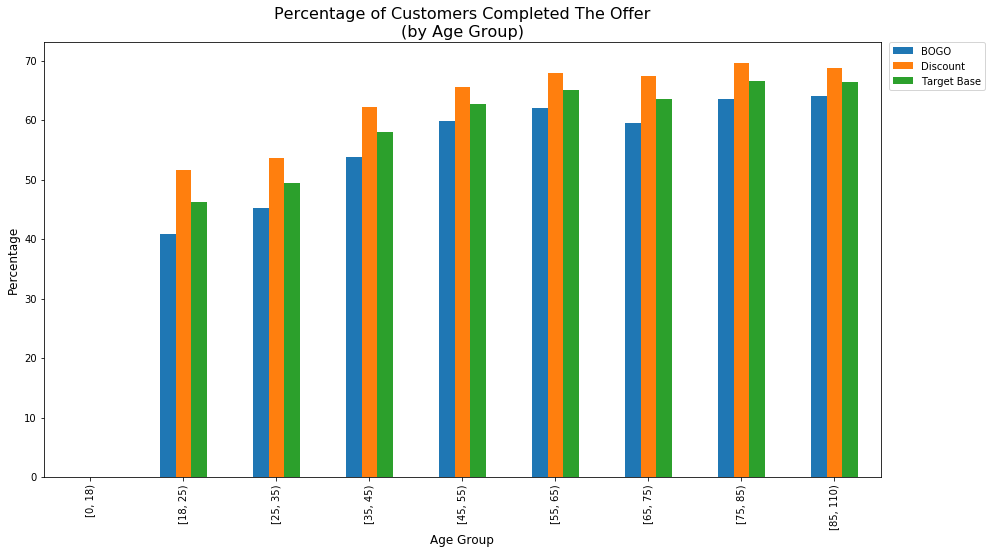

In [26]:
# By Age Group
offer_viewed_completed(profile='age_group', label='Age Group')

                       BOGO   Discount  Informational  Target Base
income_group                                                      
[0, 30000)              NaN        NaN            NaN          NaN
[30000, 40000)    79.921591  59.611540      62.690952    68.475040
[40000, 50000)    80.031153  58.363309      64.663024    68.119126
[50000, 60000)    85.502092  72.879581      74.276396    78.189540
[60000, 70000)    86.142231  72.720764      76.553672    78.790787
[70000, 80000)    83.728732  70.846099      71.574842    76.124964
[80000, 90000)    84.706346  78.843885      73.381877    80.129829
[90000, 100000)   84.178967  78.733459      75.646744    80.277521
[100000, 120000)  76.389597  62.545080      57.563025    67.161104
                       BOGO   Discount  Target Base
income_group                                       
[0, 30000)              NaN        NaN          NaN
[30000, 40000)    37.748530  48.586118    43.113688
[40000, 50000)    40.155763  51.708633    46.043385
[50

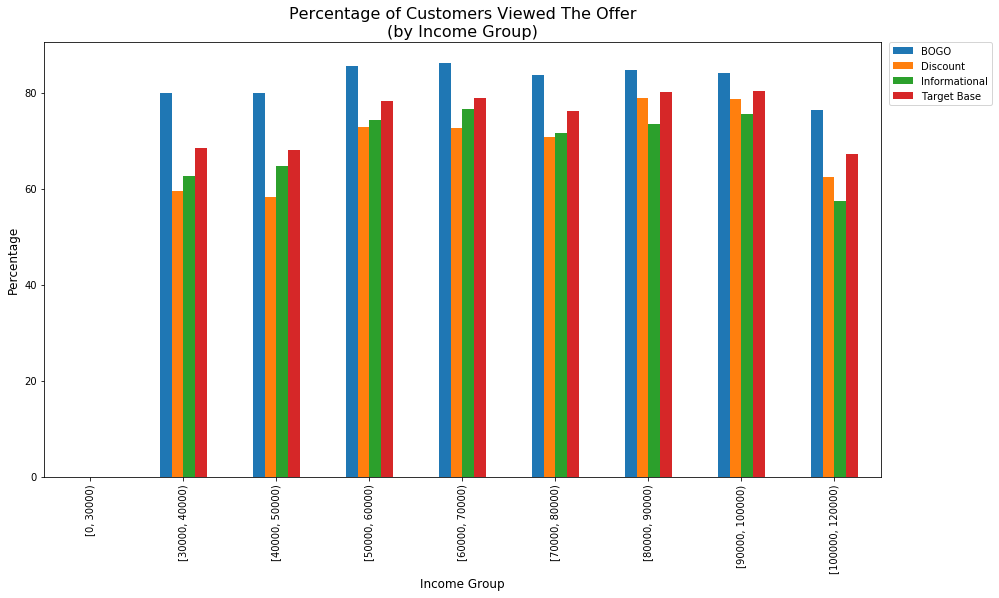

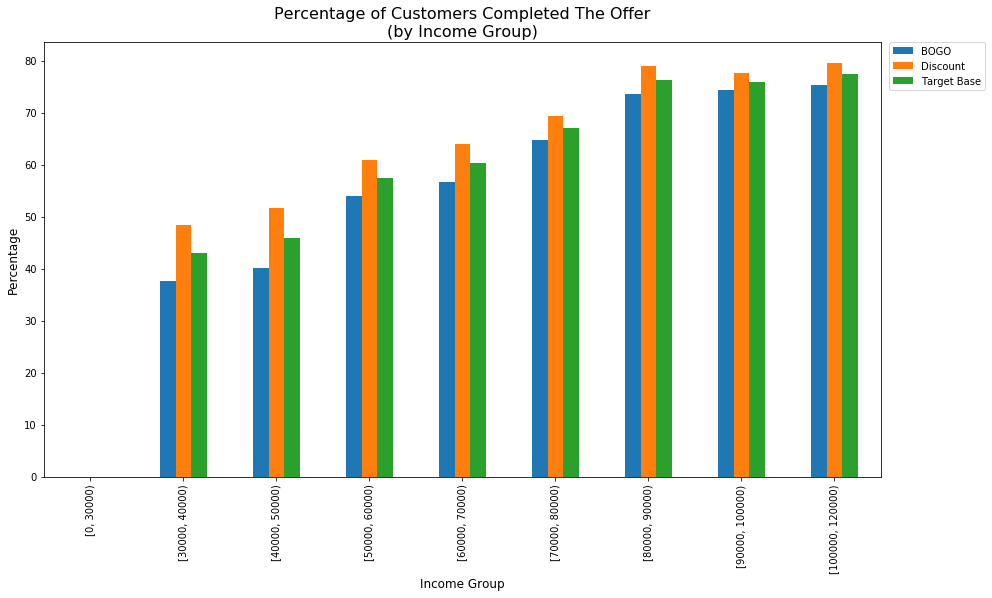

In [27]:
# By Income Group
offer_viewed_completed(profile='income_group', label='Income Group')

### Question 2

**Which offers should be recommended and sent to a particular customer to increase the sales ?**

In [27]:
def create_user_item_matrix(offer, filename):
    '''
    Return the user item matrix that indicate the number of offer complete of a particular user
    
    INPUT:
    offer - A cleaned transcript dataframe
    filename(string) - The file name that save the user item matrix
    
    OUTPUT:
    user_item_matrix - The user item matrix which 
        - "Row" : User 
        - "Column: Offer
        - "Value" : Number of offer complete by the user (NaN means NO offer given)
    
    '''
    
    # Create an empty user item matrix
    user_item_matrix = offer.groupby(['customer_id', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
    
    # Focus on BOGO and Discount offers
    user_item_matrix.drop(list(portfolio[portfolio['offer_type']=='informational']['id']), axis=1, inplace=True)  
    
    for offer_id in user_item_matrix.columns:
        print("Now processing: ", offer_id)
        num = 0
        for person in user_item_matrix.index:
            num += 1
            if num % 1000 == 0:
                print("Finished ", num/16000*100, '%')
            events = []
            for event in offer[(offer['offer_id']==offer_id) & (offer['customer_id']==person)]['event']:
                events.append(event)
            if len(events) >= 3:
                user_item_matrix.loc[person, offer_id] = 0
                for i in range(len(events)-2):
                    # Check if the transaction sequence is Offer Received -> Offer Viewed -> Offer Completed
                    # If yes, we assumed the user reacted positively with the offer we provided.
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        user_item_matrix.loc[person, offer_id] += 1
            elif len(events) > 0:
                user_item_matrix.loc[person, offer_id] = 0
    
    # store the large martix into file
    fh = open(filename, 'wb')
    pickle.dump(user_item_matrix,fh)
    fh.close()
    
    return user_item_matrix

In [28]:
full_dataframe = create_user_item_matrix(offers_details, 'user_item_matrix.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
Finished  6.25 %
Finished  12.5 %
Finished  18.75 %
Finished  25.0 %
Finished  31.25 %
Finished  37.5 %
Finished  43.75 %
Finished  50.0 %
Finished  56.25 %
Finished  62.5 %
Finished  68.75 %
Finished  75.0 %
Finished  81.25 %
Finished  87.5 %
Finished  93.75 %
Finished  100.0 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
Finished  6.25 %
Finished  12.5 %
Finished  18.75 %
Finished  25.0 %
Finished  31.25 %
Finished  37.5 %
Finished  43.75 %
Finished  50.0 %
Finished  56.25 %
Finished  62.5 %
Finished  68.75 %
Finished  75.0 %
Finished  81.25 %
Finished  87.5 %
Finished  93.75 %
Finished  100.0 %
Now processing:  2906b810c7d4411798c6938adc9daaa5
Finished  6.25 %
Finished  12.5 %
Finished  18.75 %
Finished  25.0 %
Finished  31.25 %
Finished  37.5 %
Finished  43.75 %
Finished  50.0 %
Finished  56.25 %
Finished  62.5 %
Finished  68.75 %
Finished  75.0 %
Finished  81.25 %
Finished  87.5 %
Finished  93.75 %
Finished  100.0 %
Now proces

In [29]:
full_dataframe.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
customer_id,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,1.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN


In [30]:
train_size = int(offers_details.shape[0]*0.7)
test_size = offers_details.shape[0] - train_size
train_size, test_size

(117306, 50275)

In [31]:
train_offer = offers_details[:train_size]
test_offer = offers_details[train_size:]

In [32]:
train_dataframe = create_user_item_matrix(train_offer, 'train_dataframe.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
Finished  6.25 %
Finished  12.5 %
Finished  18.75 %
Finished  25.0 %
Finished  31.25 %
Finished  37.5 %
Finished  43.75 %
Finished  50.0 %
Finished  56.25 %
Finished  62.5 %
Finished  68.75 %
Finished  75.0 %
Finished  81.25 %
Finished  87.5 %
Finished  93.75 %
Finished  100.0 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
Finished  6.25 %
Finished  12.5 %
Finished  18.75 %
Finished  25.0 %
Finished  31.25 %
Finished  37.5 %
Finished  43.75 %
Finished  50.0 %
Finished  56.25 %
Finished  62.5 %
Finished  68.75 %
Finished  75.0 %
Finished  81.25 %
Finished  87.5 %
Finished  93.75 %
Finished  100.0 %
Now processing:  2906b810c7d4411798c6938adc9daaa5
Finished  6.25 %
Finished  12.5 %
Finished  18.75 %
Finished  25.0 %
Finished  37.5 %
Finished  43.75 %
Finished  50.0 %
Finished  56.25 %
Finished  62.5 %
Finished  68.75 %
Finished  75.0 %
Finished  81.25 %
Finished  87.5 %
Finished  93.75 %
Finished  100.0 %
Now processing:  4d5c57ea9a6

In [33]:
train_dataframe.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
customer_id,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,0.0,NaN,1.0,NaN


In [34]:
test_dataframe = create_user_item_matrix(test_offer, 'test_dataframe.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
Finished  6.25 %
Finished  12.5 %
Finished  18.75 %
Finished  25.0 %
Finished  31.25 %
Finished  37.5 %
Finished  43.75 %
Finished  50.0 %
Finished  56.25 %
Finished  62.5 %
Finished  68.75 %
Finished  75.0 %
Finished  81.25 %
Finished  87.5 %
Finished  93.75 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
Finished  6.25 %
Finished  12.5 %
Finished  18.75 %
Finished  25.0 %
Finished  31.25 %
Finished  37.5 %
Finished  43.75 %
Finished  50.0 %
Finished  56.25 %
Finished  62.5 %
Finished  68.75 %
Finished  75.0 %
Finished  81.25 %
Finished  87.5 %
Finished  93.75 %
Now processing:  2906b810c7d4411798c6938adc9daaa5
Finished  6.25 %
Finished  12.5 %
Finished  18.75 %
Finished  25.0 %
Finished  31.25 %
Finished  37.5 %
Finished  43.75 %
Finished  50.0 %
Finished  56.25 %
Finished  62.5 %
Finished  68.75 %
Finished  75.0 %
Finished  81.25 %
Finished  87.5 %
Finished  93.75 %
Now processing:  4d5c57ea9a6940dd891ad53e9dbe8da0
Finished  6.25

In [35]:
test_dataframe.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
customer_id,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [28]:
# Run this cell if you want to omit the long process of matrix creation
full_dataframe = pd.read_pickle('user_item_matrix.p')
train_dataframe = pd.read_pickle('train_dataframe.p')
test_dataframe = pd.read_pickle('train_dataframe.p')

In [29]:
def FunkSVD(complete_mat, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    complete_mat - (numpy array) A matrix with users as rows, offers as columns, and offer completed as values
    latent_features - (int) The number of latent features used
    learning_rate - (float) The learning rate 
    iters - (int) The number of iterations
    
    OUTPUT:
    user_mat - (numpy array) A user by latent feature matrix
    offer_mat - (numpy array) A latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = complete_mat.shape[0]
    n_offers = complete_mat.shape[1]
    num_complete = np.count_nonzero(~np.isnan(complete_mat))
    
    # Initialize the user and offer matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # Initialize sse at 0 for first iteration
    sse_accum = 0
    
    # Keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # For each iteration
    for iteration in range(iters):

        # Update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # If the rating exists
                if complete_mat[i, j] >= 0:
                    
                    # Compute the error as the actual minus the dot product of the user and offer latent features
                    diff = complete_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # Update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # Print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_complete))
        
    return user_mat, offer_mat

In [30]:
# Create user-by-item matrix - nothing to do here
train_dataframe_np = np.array(train_dataframe)

# Fit FunkSVD with the specified hyper parameters to the training data
user_mat, offer_mat = FunkSVD(train_dataframe_np, latent_features=15, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.317947
2 		 0.267447
3 		 0.267096
4 		 0.266740
5 		 0.266381
6 		 0.266017
7 		 0.265649
8 		 0.265277
9 		 0.264899
10 		 0.264516
11 		 0.264127
12 		 0.263731
13 		 0.263329
14 		 0.262920
15 		 0.262502
16 		 0.262077
17 		 0.261642
18 		 0.261198
19 		 0.260744
20 		 0.260278
21 		 0.259800
22 		 0.259310
23 		 0.258806
24 		 0.258287
25 		 0.257753
26 		 0.257202
27 		 0.256632
28 		 0.256044
29 		 0.255435
30 		 0.254804
31 		 0.254149
32 		 0.253469
33 		 0.252763
34 		 0.252028
35 		 0.251263
36 		 0.250466
37 		 0.249634
38 		 0.248766
39 		 0.247860
40 		 0.246913
41 		 0.245923
42 		 0.244888
43 		 0.243805
44 		 0.242672
45 		 0.241486
46 		 0.240245
47 		 0.238947
48 		 0.237588
49 		 0.236167
50 		 0.234680
51 		 0.233127
52 		 0.231503
53 		 0.229809
54 		 0.228041
55 		 0.226198
56 		 0.224279
57 		 0.222282
58 		 0.220206
59 		 0.218052
60 		 0.215819
61 		 0.213507
62 		 0.211117
63 		 0.208650
64 		 0

In [34]:
# Fit FunkSVD with the specified hyper parameters to the training data (with latent features = 10)
user_mat_10, offer_mat_10 = FunkSVD(train_dataframe_np, latent_features=10, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.296447
2 		 0.265917
3 		 0.265463
4 		 0.264992
5 		 0.264520
6 		 0.264045
7 		 0.263567
8 		 0.263087
9 		 0.262604
10 		 0.262117
11 		 0.261627
12 		 0.261134
13 		 0.260637
14 		 0.260136
15 		 0.259630
16 		 0.259120
17 		 0.258604
18 		 0.258083
19 		 0.257557
20 		 0.257024
21 		 0.256484
22 		 0.255938
23 		 0.255384
24 		 0.254821
25 		 0.254251
26 		 0.253670
27 		 0.253080
28 		 0.252480
29 		 0.251868
30 		 0.251244
31 		 0.250608
32 		 0.249957
33 		 0.249293
34 		 0.248613
35 		 0.247916
36 		 0.247203
37 		 0.246470
38 		 0.245718
39 		 0.244946
40 		 0.244151
41 		 0.243333
42 		 0.242491
43 		 0.241623
44 		 0.240727
45 		 0.239803
46 		 0.238848
47 		 0.237862
48 		 0.236842
49 		 0.235788
50 		 0.234697
51 		 0.233568
52 		 0.232400
53 		 0.231190
54 		 0.229938
55 		 0.228641
56 		 0.227298
57 		 0.225909
58 		 0.224471
59 		 0.222983
60 		 0.221445
61 		 0.219854
62 		 0.218211
63 		 0.216515
64 		 0

In [35]:
# Fit FunkSVD with the specified hyper parameters to the training data (with latent features = 20)
user_mat_20, offer_mat_20 = FunkSVD(train_dataframe_np, latent_features=20, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.330904
2 		 0.269151
3 		 0.268854
4 		 0.268542
5 		 0.268223
6 		 0.267898
7 		 0.267567
8 		 0.267228
9 		 0.266881
10 		 0.266527
11 		 0.266163
12 		 0.265789
13 		 0.265405
14 		 0.265010
15 		 0.264603
16 		 0.264183
17 		 0.263749
18 		 0.263301
19 		 0.262836
20 		 0.262355
21 		 0.261855
22 		 0.261336
23 		 0.260795
24 		 0.260233
25 		 0.259646
26 		 0.259033
27 		 0.258393
28 		 0.257724
29 		 0.257023
30 		 0.256288
31 		 0.255518
32 		 0.254711
33 		 0.253862
34 		 0.252971
35 		 0.252035
36 		 0.251051
37 		 0.250015
38 		 0.248926
39 		 0.247781
40 		 0.246576
41 		 0.245308
42 		 0.243975
43 		 0.242574
44 		 0.241101
45 		 0.239554
46 		 0.237930
47 		 0.236227
48 		 0.234442
49 		 0.232573
50 		 0.230617
51 		 0.228574
52 		 0.226441
53 		 0.224219
54 		 0.221906
55 		 0.219502
56 		 0.217008
57 		 0.214425
58 		 0.211753
59 		 0.208996
60 		 0.206155
61 		 0.203235
62 		 0.200237
63 		 0.197167
64 		 0

In [31]:
def predict_reaction(user_matrix, offer_matrix, user_id, offer_id):
    '''
    We can use this to make predictions for how users would react with the offers
    
    INPUT:
    user_matrix - User by latent factor matrix
    offer_matrix - Latent factor by offer matrix
    user_id - The user_id from the reviews df
    offer_id - The offer_id according the offers df
    
    OUTPUT:
    pred - The predicted reaction for user_id-offer_id according to FunkSVD
    '''
    
    try:
        # Use the training data to create a series of users and movies that matches the ordering in training data
        user_ids_series = np.array(train_dataframe.index)
        offer_ids_series = np.array(train_dataframe.columns)

        # User row and Movie Column
        user_row = np.where(user_ids_series == user_id)[0][0]
        offer_col = np.where(offer_ids_series == offer_id)[0][0]

        # Take dot product of that row and column in U and V to make prediction
        pred = np.dot(user_matrix[user_row, :], offer_matrix[:, offer_col])
        
        return pred
    
    except:
        #print("I'm sorry, but a prediction cannot be made for this user-offer pair. It looks like one of these items does not exist in our current database.")
    
        return None

In [32]:
def validation(test_dataframe, user_mat, offer_mat):
    '''Measure the squared errors for the prediction'''
    
    num_complete = np.count_nonzero(~np.isnan(test_dataframe))
    
    sse_accum = 0
    
    for user_id in test_dataframe.index:
        for offer_id in test_dataframe.columns:
            if ~np.isnan(test_dataframe.loc[user_id, offer_id]):
                predict_value = predict_reaction(user_mat, offer_mat, user_id, offer_id)
                if predict_value != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = test_dataframe.loc[user_id, offer_id] - predict_reaction(user_mat, offer_mat, user_id, offer_id)

                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
    
    print(sse_accum / num_complete)

In [33]:
# Validation for latent features = 15
validation(test_dataframe, user_mat, offer_mat)

0.00638626870173


In [36]:
# Validation for latent features = 10
validation(test_dataframe, user_mat_10, offer_mat_10)

0.00782367844481


In [37]:
# Validation for latent features = 20
validation(test_dataframe, user_mat_20, offer_mat_20)

0.00748101415977


In [38]:
def best_sale_offer(user_item_matrix):
    # Find out which offer sells the best

    offer_gain = []
    for offer_id in user_item_matrix.columns:
        offer_gain.append([offer_id, transcript[(transcript['person'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()])

    offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'gain'])
    offer_value['gain'] = pd.to_numeric(offer_value['gain'])
    offer_value.sort_values(by='gain', ascending=False, inplace=True)
    print(offer_value)
    
    best_sale = offer_value.plot(kind='bar', title='Sale Amount of Different Offers')
    best_sale.set_xlabel('Offer Number')
    best_sale.set_ylabel('Sales Amount')
    
    return offer_value

In [39]:
def recommend_offer(user_id, user_mat, offer_mat):
    recommend = {}
    for offer_id in train_dataframe.columns:
        pred_val = predict_reaction(user_mat, offer_mat, user_id, offer_id)
        if pred_val != None:
            recommend[offer_id] = pred_val
        else:
            break
    if pred_val == None:
        print("Because this customer wasn't in our database, we're recommended the Top Best Sales offers for all customers.")
        top_offer = best_sale_offer(full_dataframe)
        for offer_id in top_offer['offer_id']:
            print("Offer ID: ", offer_id)
    else:
        print("Recommended offers for Customer ", user_id)
        for offer_id, pred_val in sorted(recommend.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print("Offer ID: ", offer_id, " Predicted Value: ", round(pred_val,2))

In [40]:
# Recommended offer to a particular customer
recommend_offer('0610b486422d4921ae7d2bf64640c50b', user_mat, offer_mat)

Recommended offers for Customer  0610b486422d4921ae7d2bf64640c50b
Offer ID:  2298d6c36e964ae4a3e7e9706d1fb8c2  Predicted Value:  1.34
Offer ID:  f19421c1d4aa40978ebb69ca19b0e20d  Predicted Value:  1.04
Offer ID:  2906b810c7d4411798c6938adc9daaa5  Predicted Value:  0.99
Offer ID:  ae264e3637204a6fb9bb56bc8210ddfd  Predicted Value:  0.19
Offer ID:  fafdcd668e3743c1bb461111dcafc2a4  Predicted Value:  0.17
Offer ID:  4d5c57ea9a6940dd891ad53e9dbe8da0  Predicted Value:  0.13
Offer ID:  0b1e1539f2cc45b7b9fa7c272da2e1d7  Predicted Value:  0.04
Offer ID:  9b98b8c7a33c4b65b9aebfe6a799e6d9  Predicted Value:  -0.09


In [44]:
offer_1 = cleaned_portfolio[cleaned_portfolio['offer_id']=='2298d6c36e964ae4a3e7e9706d1fb8c2']
offer_1.head()

,difficulty,duration,offer_id,reward,web,email,mobile,social,bogo,discount,informational
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0


In [45]:
offer_2 = cleaned_portfolio[cleaned_portfolio['offer_id']=='f19421c1d4aa40978ebb69ca19b0e20d']
offer_2.head()

,difficulty,duration,offer_id,reward,web,email,mobile,social,bogo,discount,informational
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0


In [48]:
offer_3 = cleaned_portfolio[cleaned_portfolio['offer_id']=='2906b810c7d4411798c6938adc9daaa5']
offer_3.head()

,difficulty,duration,offer_id,reward,web,email,mobile,social,bogo,discount,informational
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0


Because this customer wasn't in our database, we're recommended the Top Best Sales offers for all customers.
                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94
Offer ID:  fafdcd668e3743c1bb461111dcafc2a4
Offer ID:  2298d6c36e964ae4a3e7e9706d1fb8c2
Offer ID:  f19421c1d4aa40978ebb69ca19b0e20d
Offer ID:  4d5c57ea9a6940dd891ad53e9dbe8da0
Offer ID:  ae264e3637204a6fb9bb56bc8210ddfd
Offer ID:  2906b810c7d4411798c6938adc9daaa5
Offer ID:  9b98b8c7a33c4b65b9aebfe6a799e6d9
Offer ID:  0b1e1539f2cc45b7b9fa7c272da2e1d7


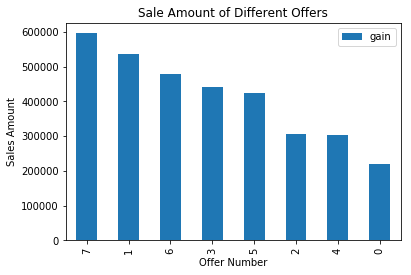

In [41]:
# We recommend Top Best Sales offers to a new customer
recommend_offer('new_user', user_mat, offer_mat)

In [49]:
offer = cleaned_portfolio[cleaned_portfolio['offer_id']=='fafdcd668e3743c1bb461111dcafc2a4']
offer.head()

,difficulty,duration,offer_id,reward,web,email,mobile,social,bogo,discount,informational
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
